<a href="https://colab.research.google.com/github/ljloaizap/CodingWipiti/blob/main/kb_jupyter/notebooks/Midiendito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midiendito

## Init

In [83]:
from datetime import datetime
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd

In [67]:
# Spreadsheet consts
SS_TITLE = "Midiendito"
SS_TAB_NAME = "Data"
DATA_INTERVAL = "A2:Z500"

In [17]:
# Authenticate
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## ETG

### Extract

In [4]:
def read_data():
    sheet = gc.open(SS_TITLE).worksheet(SS_TAB_NAME)
    data = sheet.get(DATA_INTERVAL)
    return pd.DataFrame(data[1:], columns=data[0])  # First row as headers

In [99]:
df_spreadsheet = read_data()

### Transform

In [6]:
def filter_date_and_active(df_full, graph_ini_date, graph_end_date):
    # Filter active records
    df_full["active"] = df_full["active"].str.upper().eq("TRUE").astype(bool)
    df_full = df_full[df_full["active"] == True].reset_index(drop=True)

    # Filter by date range
    df_full['record_date'] = df_full['record_date'].astype('datetime64[ns]')
    df = df_full[df_full['record_date'].between(graph_ini_date, graph_end_date)]

    print(f'Records: {len(df)} -- From "{graph_ini_date}" to "{graph_end_date}"')
    return df

In [77]:
def clean_data(df):
    # Alter data to handle numeric values with comma as decimal separator
    numeric_columns = [
        'water_liters',
        'sleep_hours_int',
        'sleep_minutes',
        'sleep_hours_total',
        'workout_minutes',
        'read_hours',
        'study_hours',
        'deep_work_hours',
        'todo_points',
        'todo_achieved',
        'todo_score'
    ]

    for nc in numeric_columns:
        df.loc[:, nc] = df[nc].str.replace(",", ".")  # First, replace commas
        df.loc[:, nc] = pd.to_numeric(df[nc], errors="coerce").fillna(0)

    # Alter data to handle time columns
    df.loc[:, "work_init_time"] = df["work_init_time"].str.zfill(5) + ":00"
    df.loc[:, "work_init_time"] = pd.to_timedelta(df["work_init_time"], errors='coerce')

    df.loc[:, "work_end_time"] = df["work_end_time"].str.zfill(5) + ":00"
    df.loc[:, "work_end_time"] = pd.to_timedelta(df["work_end_time"], errors='coerce')

    return df

In [8]:
def change_columns_data_type(df):
    df = df.astype({
        "id": "Int64",
        "record_date": "datetime64[ns]",
        "active": "boolean",
        "water_liters": "float64",
        "sleep_hours_int": "Int64",
        "sleep_minutes": "Int64",
        "sleep_hours_total": "float64",
        "orchard": "string",
        "workout_minutes": "Int64",
        "female_cycle": "string",
        "predominant_mood": "string",
        "mind_mood": "string",
        "place": "string",
        "sunrise": "string",
        "scream": "string",
        "pray": "string",
        "read_hours": "float64",
        "study_hours": "float64",
        "deep_work_hours": "float64",
        "todo_points": "Int64",
        "todo_achieved": "Int64",
        "todo_score": "float64"
    })

    return df

In [9]:
def add_flag_columns(df):
    # Yes/no
    df['flg_pray'] = df['pray'] == "Sí"
    df['flg_scream_ok'] = df['scream'] == "No"  # Opposite. If "No", then it's fine, hence, True
    df['flg_orchard'] = df['orchard'] == "Sí"

    # Int vals
    df['flg_workout'] = df['workout_minutes'] > 0
    df['flg_read'] = df['read_hours'] > 0
    df['flg_study'] = df['study_hours'] > 0

    return df

### Graph

In [10]:
def set_bar_chart_flags(df_graph, axes, index):
    # Filter the relevant columns
    df_flags = df_graph[['flg_pray', 'flg_workout', 'flg_read', 'flg_study']]

    # Count True/False occurrences per column and normalize to percentage
    bar_counts = df_flags.apply(lambda col: col.value_counts(normalize=True) * 100).fillna(0)

    # Stacked bar chart
    bar_counts.T.plot(kind="bar", stacked=True, color=["#f34646", "#31cb54f2"], ax=axes[index])
    axes[index].set_xlabel("")
    axes[index].set_ylabel("Percentage (%)")
    axes[index].set_title('Flags', fontsize=10, fontweight='bold')
    axes[index].legend(["False", "True"])

    # Rotate the x-axis labels to appear horizontal
    axes[index].tick_params(axis='x', rotation=0)

    # Modify labels to remove prefix
    axes[index].set_xticklabels([col.replace("flg_", "").capitalize() for col in bar_counts.columns])

    # Annotate bars with percentage values
    for p in axes[index].patches:
        if p.get_height() > 0:
            axes[index].text(p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2,
                        f"{p.get_height():.1f}%", ha="center", va="center", fontsize=8, color="white")

In [11]:
def set_line_chart_sleep(df_graph, axes, index):
    df_graph.plot(kind='line', x='record_date', y='sleep_hours_total', ax=axes[index], color='orange')
    axes[index].set_xticklabels([])  # Hide x-axis labels
    axes[index].set_title('Sleep', fontsize=10, fontweight='bold')
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")

In [95]:
def set_pie_chart_mind(df_graph, axes, index):
    pie_color_map = {
        "Súper": "#0c9a0c",
        "Bien": "#5eb75e",
        "Neutral": "#b8b4b4e6",
        "Auch": "#f91b1bd6",
        "Paila": "#e40303"
    }

    pie_counts = df_graph["mind_mood"].value_counts()
    pie_counts = pie_counts.reindex(pie_color_map.keys()).dropna()
    #print(pie_counts)

    pie_counts.plot(kind="pie", autopct="%1.1f%%", ax=axes[index], colors=[pie_color_map[val] for val in pie_counts.index])

    axes[index].set_title('Mind', fontsize=10, fontweight='bold')
    axes[index].set_ylabel("")

In [13]:
def set_line_chart_water(df_graph, axes, index):
    df_graph.plot(kind='line', x='record_date', y='water_liters', ax=axes[index])
    #axes[2].xaxis.set_major_locator(plt.MaxNLocator(10))  # Set around 5 ticks automatically
    axes[index].set_xticklabels([])  # Hide x-axis labels
    axes[index].set_title('Water', fontsize=10, fontweight='bold')
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")

In [14]:
import matplotlib.pyplot as plt

def render_charts(df_graph, graph_ini_date, graph_end_date):
    # Checks
    if len(df_graph) == 0:
        print(f'\n[Info] No records to plot')  #  between {graph_ini_date} and {graph_end_date}.
        return

    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))

    # Set charts
    set_bar_chart_flags(df_graph, axes, 0)
    set_line_chart_sleep(df_graph, axes, 1)
    set_pie_chart_mind(df_graph, axes, 2)
    set_line_chart_water(df_graph, axes, 3)

    # Figure
    fig_title = f'Midiendito ({graph_ini_date} — {graph_end_date})'
    fig.suptitle(fig_title, fontsize=13, y=0.98, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Main

In [76]:
#graph_ini_date, graph_end_date = '2025-01-01', '2025-03-31'
def run_etg(graph_ini_date, graph_end_date):

  # Extract
  df_full = df_spreadsheet.copy()  # read_data()

  # Transform
  df = filter_date_and_active(df_full, graph_ini_date, graph_end_date)
  df = clean_data(df)
  df = change_columns_data_type(df)
  df = add_flag_columns(df)

  # Graph
  df_graph = df
  render_charts(df_graph, graph_ini_date, graph_end_date)

Records: 31 -- From "2024-12-01" to "2024-12-31"


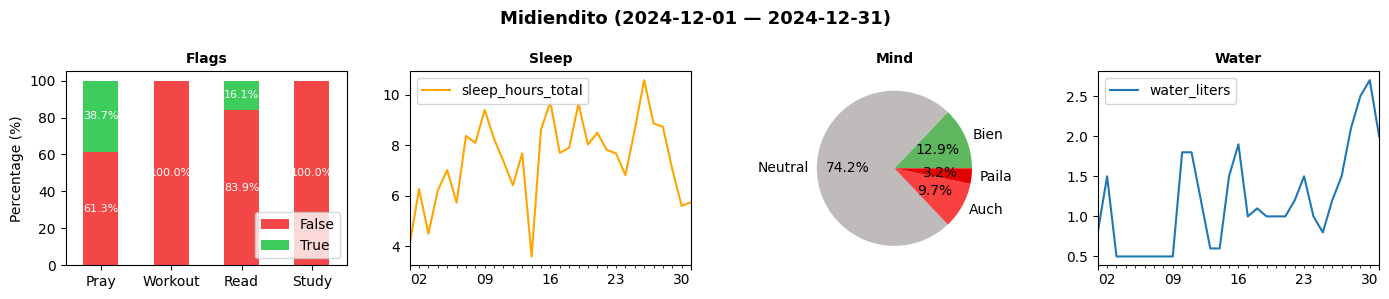

In [100]:
run_etg('2024-12-01', '2024-12-31')

Records: 31 -- From "2025-01-01" to "2025-01-31"


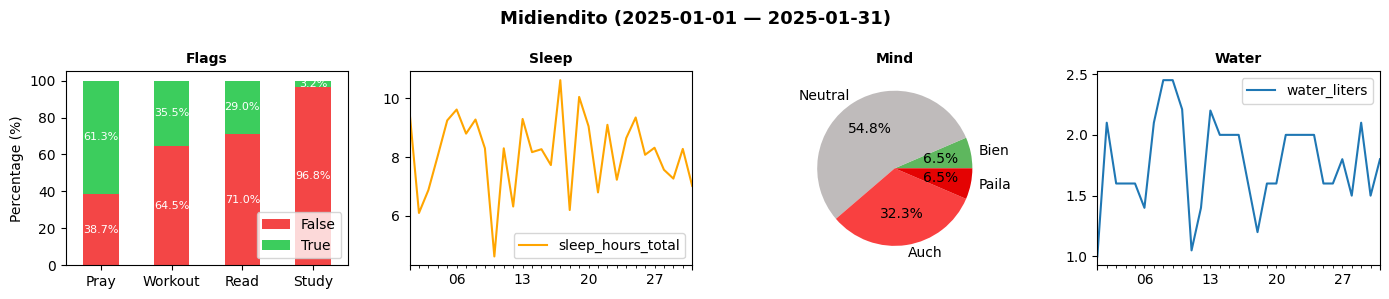

In [101]:
run_etg('2025-01-01', '2025-01-31')

Records: 28 -- From "2025-02-01" to "2025-02-28"


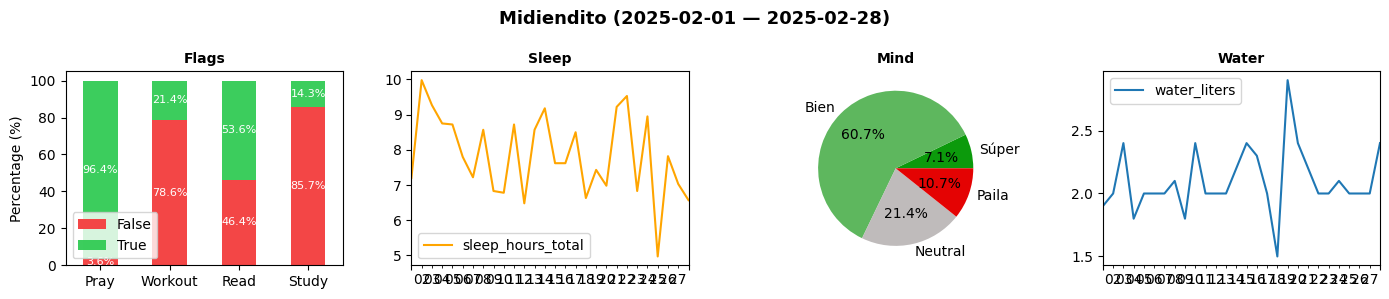

In [102]:
run_etg('2025-02-01', '2025-02-28')

Records: 31 -- From "2025-03-01" to "2025-03-31"


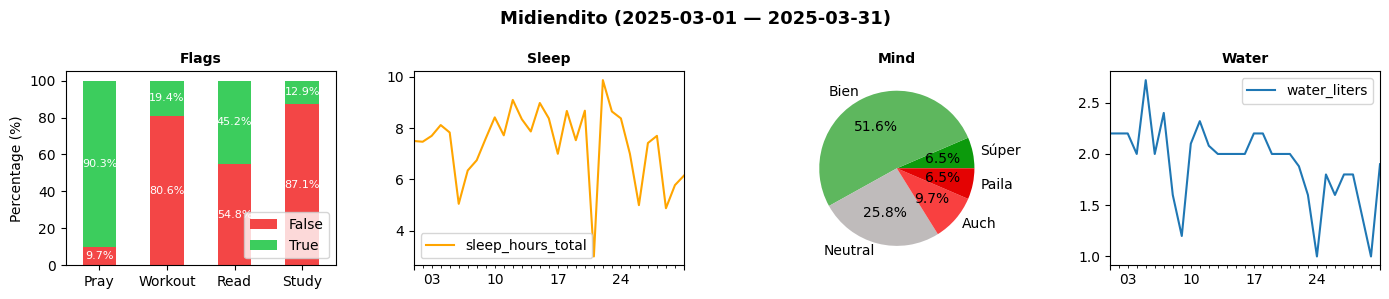

In [103]:
run_etg('2025-03-01', '2025-03-31')

Records: 6 -- From "2025-04-01" to "2025-04-07"


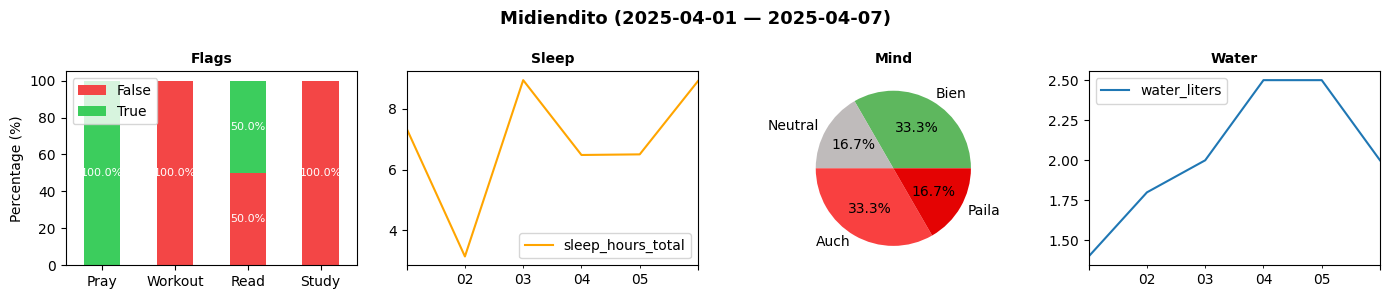

In [104]:
# Current month...
dnow = datetime.today()
run_etg(str(datetime(dnow.year, dnow.month, 1))[:10], str(dnow)[:10])